In [49]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from PIL import Image
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

## Logistic Regression

In [5]:
def LogReg(X_train, y_train, X_test, y_test, lr=0.01, batch_size=10, max_iterations=1000, min_profit_step=0.001):
    X_ = np.concatenate((np.ones([X_train.shape[0], 1]), X_train), axis=1)
    X_test_ = np.concatenate((np.ones([X_test.shape[0], 1]), X_test), axis=1)
    W = np.ones([X.shape[1]+1, 1]) * 0.0001
    iterations = 0
    accuracy_per_it = []
    n = X_.shape[0]
    prev_cost = None
        
    while(iterations < max_iterations):
        sample_ids = np.random.randint(0, n, batch_size)
        sample_X = X_[sample_ids, :]
        sample_y = y_train[sample_ids]
        values_cost = []
        for i in range(batch_size):
            exp = 1 + np.exp(sample_y[i] * np.dot(W.flatten(), sample_X[i, :]))
            values_cost.append((sample_X[i, :] * sample_y[i]) / exp)
        previous_W = W
        W = W + lr * (np.sum(np.array(values_cost), axis=0).reshape(W.shape))
        cost = cost_function(X_test_, y_test, W)
        if prev_cost:
            cost_diff = prev_cost - cost
            if (cost_diff < 0) or (cost_diff < min_profit_step*prev_cost):
                W = previous_W
                break
        prev_cost = cost
        accuracy_per_it.append(accuracy_score(predict(X_test, W), y_test))
        iterations += 1
    return accuracy_per_it, W
    
def predict(X, w):
    X_ = np.concatenate((np.ones([X.shape[0], 1]), X), axis=1)
    predictions_0_1 = 1 / (1 + np.exp(-1 * np.dot(X_, w)))
    return [1 if p > 0.5 else -1 for p in predictions_0_1]
def cost_function( X, y,w):
    return np.mean(np.log(1 + np.exp(-y * np.dot(X, w).flatten())))

### Spam

In [6]:
data = pd.read_csv('spam.csv')
data.label = data.label.map(lambda y: y if y == 1 else -1)
X = data[data.columns.difference(['label'])].values
y= data.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
accuracy_per_it, w=LogReg(X_train, y_train, X_test, y_test, lr=0.001, batch_size=16, max_iterations=1000, min_profit_step=0.0001)

Accuracy: 0.8968512486427795


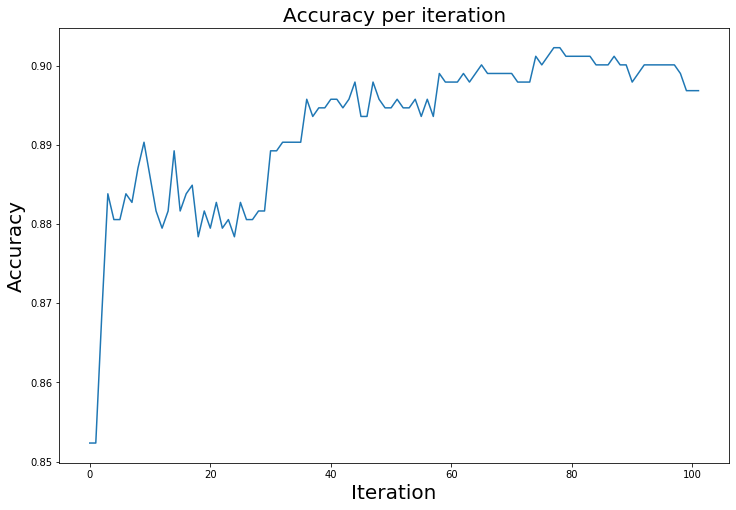

In [8]:
accuracy=accuracy_score(predict(X_test, w), y_test)
print("Accuracy:", accuracy)
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(accuracy_per_it)),accuracy_per_it)
plt.title('Accuracy per iteration', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Iteration', fontsize=20)
plt.show()

### Cancer

In [9]:
data = pd.read_csv('cancer.csv')
data['int_label'] = data.label.map({'M':1, 'B':-1})
data['label'] = data.int_label
data.drop('int_label', axis=1, inplace=True)
X = data[data.columns.difference(['label'])].values
y = data.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
accuracy_per_it, w=LogReg(X_train, y_train, X_test, y_test, lr=0.001, batch_size=16, max_iterations=1000, min_profit_step=0.0001)

Accuracy: 0.9824561403508771


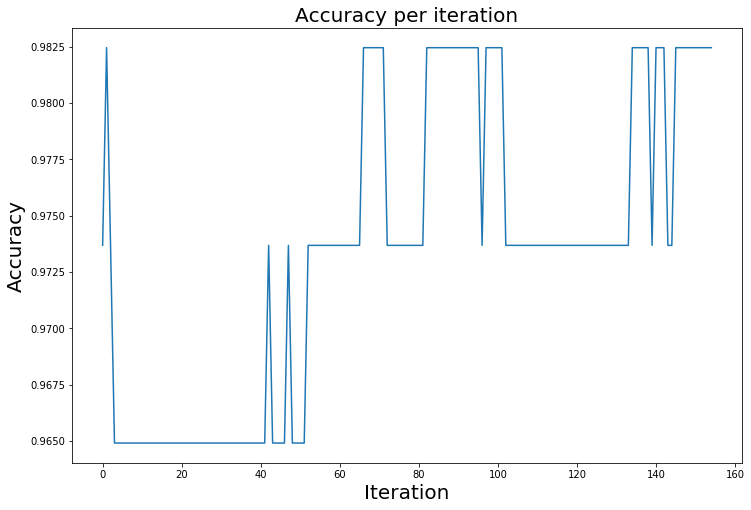

In [11]:
accuracy=accuracy_score(predict(X_test, w), y_test)
print("Accuracy:", accuracy)
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(accuracy_per_it)),accuracy_per_it)
plt.title('Accuracy per iteration', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Iteration', fontsize=20)
plt.show()

## Transformation for MNIST and notMNIST

### MNIST

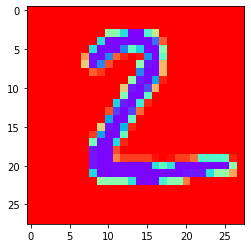

In [35]:
data=pd.read_csv("mnist.csv")
X = data.loc[:,data.columns != "label"].values   
y = data.label.values
plt.imshow(X[1, :].reshape([int(np.sqrt(X[1, :].flatten().shape[0])), int(np.sqrt(X[1, :].flatten().shape[0]))]), cmap='rainbow_r')
plt.show()

### notMNIST

Shape: (28, 28)


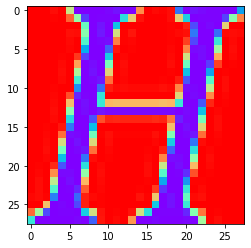

In [40]:
pic = np.array(Image.open("notMNIST_small/H/Q29uY29yZGUgTm92YSAoUikgRXhwZXJ0IEl0YWxpYyBPc0YudHRm.png"))
print("Shape:", pic.shape)
plt.imshow(pic, cmap='rainbow_r')
plt.show()

## Neural Network for MNIST

In [64]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class Print(nn.Module):
    def forward(self, x):
        print(x.size())
        return x
def activation_function(mode):
    if mode == 'relu':
        return nn.ReLU()
    if mode == 'tanh':
        return nn.Tanh()
    if mode == 'sigmoid':
        return nn.LogSigmoid()
def train_network(train_loader, test_loader, mode, epochs):
    model = nn.Sequential()
    model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1))
    model.add_module('a1', activation_function(mode))
    model.add_module('conv2', nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1))
    model.add_module('a2', activation_function(mode))
    model.add_module('conv3', nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1))
    model.add_module('a3', activation_function(mode))
    model.add_module('flatten', Flatten())
    model.add_module('dense1', nn.Linear(6272, 64))
    model.add_module('a4', activation_function(mode))
    model.add_module('dense2', nn.Linear(64, 64))
    model.add_module('a5', activation_function(mode))
    model.add_module('out', nn.Linear(64, 10))
    model = model.double()
    crit = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        running_loss = 0
        model.train()
        for images, labels in train_loader:
            train = Variable(images.view(-1,1,28,28))
            labels = Variable(labels)

            opt.zero_grad()

            output = model(train.double())
            loss = crit(output, labels)
            loss.backward()
            opt.step()
            running_loss += loss.item()

        test_loss = 0
        accuracy = 0

        with torch.no_grad():
            model.eval()
            for images, labels in test_loader:
                test = Variable(images.view(-1,1,28,28))
                labels = Variable(labels)

                log_ps = model(test)
                test_loss += crit(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

In [65]:
data = pd.read_csv("mnist.csv")
X = data.loc[:, data.columns != "label"].values/255   
y = data.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)
train = torch.utils.data.TensorDataset(X_train, y_train)
test = torch.utils.data.TensorDataset(X_test, y_test)
train_ = torch.utils.data.DataLoader(train, batch_size=64, shuffle=False)
test_ = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False)

In [66]:
train_network(train_, test_, 'sigmoid', 5)

Epoch: 1/5..  Training Loss: 2.315..  Test Loss: 2.303..  Test Accuracy: 0.102
Epoch: 2/5..  Training Loss: 2.087..  Test Loss: 0.682..  Test Accuracy: 0.774
Epoch: 3/5..  Training Loss: 0.394..  Test Loss: 0.312..  Test Accuracy: 0.908
Epoch: 4/5..  Training Loss: 0.252..  Test Loss: 0.257..  Test Accuracy: 0.926
Epoch: 5/5..  Training Loss: 0.195..  Test Loss: 0.228..  Test Accuracy: 0.931


In [67]:
train_network(train_, test_, 'tanh', 5)

Epoch: 1/5..  Training Loss: 0.750..  Test Loss: 0.333..  Test Accuracy: 0.917
Epoch: 2/5..  Training Loss: 0.273..  Test Loss: 0.251..  Test Accuracy: 0.936
Epoch: 3/5..  Training Loss: 0.186..  Test Loss: 0.213..  Test Accuracy: 0.935
Epoch: 4/5..  Training Loss: 0.138..  Test Loss: 0.198..  Test Accuracy: 0.943
Epoch: 5/5..  Training Loss: 0.104..  Test Loss: 0.180..  Test Accuracy: 0.951


In [68]:
train_network(train_, test_, 'relu', 5)

Epoch: 1/5..  Training Loss: 1.079..  Test Loss: 0.358..  Test Accuracy: 0.891
Epoch: 2/5..  Training Loss: 0.294..  Test Loss: 0.290..  Test Accuracy: 0.915
Epoch: 3/5..  Training Loss: 0.214..  Test Loss: 0.248..  Test Accuracy: 0.930
Epoch: 4/5..  Training Loss: 0.169..  Test Loss: 0.218..  Test Accuracy: 0.943
Epoch: 5/5..  Training Loss: 0.141..  Test Loss: 0.231..  Test Accuracy: 0.942
